[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/CryptoDataProcessing/blob/main/3_data_preprocessing.ipynb)

### In this notebook I present methodology of preprocessing each individual features, especially standardization methods that significantly improve numerical stability and performance of machine learning models, which will be trained on this data.

In [1]:
import random
import zipfile
from concurrent.futures import ALL_COMPLETED, ThreadPoolExecutor, wait
from datetime import date
from os import makedirs
from os.path import exists, join

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import talib
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

# I put the functions defined in previous notebooks in the crypto_data.py file and we will import them from there
from crypto_data import (
    daterange,
    download_extract_zip,
    get_trades,
    merge_ohlc,
    trades2ohlc,
)

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

Constants that define the scope and characteristics of our data set

In [4]:
BASE_BINANCE_DATA_URL = "https://data.binance.vision"

# File save locations. Trades files are saved locally, when downloading them,
# it is first checked if the file already exists and then it is downloaded from binance servers
DATA_DIR = "data"
TRADES_DIR = join(DATA_DIR, "trades")
OHLCV_DIR = join(DATA_DIR, "ohlcv")

# Train part between START_DATE and TRAIN_END,
# val part between TRAIN_END and VAL_END,
# test part between VAL_END and END_DATE
START_DATE = date(2022, 3, 20)
TRAIN_END = date(2022, 4, 1)
VAL_END = date(2022, 4, 5)
END_DATE = date(2022, 4, 10)

PAIRS = ["apeusdt", "ethusdt", "algousdt"]
# Primary time unit used to compute the length of the intervals must be pandas.tseries.offsets. eg. Second, Minute etc.
BASE_TIME_OFFSET = pd.tseries.offsets.Minute()
OHLC_INTERVALS = [10, 60]

# the assumption is that our final data generator will return segments of the time series
# where the window length will be DATASET_SEQ_LEN steps.
# For each time interval (we design a generator for the multi-input model, each time interval will give a separate input),
# the input shape for models will have dimensions [BATCH_SIZE, DATASET_SEQ_LEN, FEATURES_NUMBER].
# This value has to be specified now,
# because it is used for some transformations. We can use different window size for different time intervals.
DATASET_SEQ_LEN = {interval: 30 for interval in OHLC_INTERVALS}

# some technical indicators needs some previous data points to calculate value,
# DROP_N_FIRST_ROWS sets number of first lines to drop, this way we put more features in our dataset.
# May be diffrient for diffrient intervals
DROP_N_FIRST_ROWS = {interval: 96 for interval in OHLC_INTERVALS}

# Some collumns are not usefull, some we may want to delete because we do not match our specific reserch,
# in this case we drop columns that had empty values at the end of the dataset.
# May be diffrient for diffrient intervals
DROP_COLUMNS_NAMES = {
    interval: [
        "TOS_STDEVALL_LR",
        "TOS_STDEVALL_L_1",
        "TOS_STDEVALL_U_1",
        "TOS_STDEVALL_L_2",
        "TOS_STDEVALL_U_2",
        "TOS_STDEVALL_L_3",
        "TOS_STDEVALL_U_3",
        "DPO_20",
        "ICS_26",
        "EOM_14_100000000",
        "QQEl_14_5_4.236",
        "QQEs_14_5_4.236",
    ]
    for interval in OHLC_INTERVALS
}

# Price-related features standardization strategy
PRICE_SCALING_METHOD = "standarised_max_pct_chenge"  # or 'standarised_pct_chenge'

Categorization of features from previous notebooks

In [5]:
MONOTONIC_COL = [
    "SQZ_NO",
    "SQZPRO_NO",
    "TOS_STDEVALL_LR",
    "TOS_STDEVALL_L_1",
    "TOS_STDEVALL_U_1",
    "TOS_STDEVALL_L_2",
    "TOS_STDEVALL_U_2",
    "TOS_STDEVALL_L_3",
    "TOS_STDEVALL_U_3",
]

PAIR_COL = [
    "HILOl_13_21",
    "HILOs_13_21",
    "PSARl_0.02_0.2",
    "PSARs_0.02_0.2",
    "QQEl_14_5_4.236",
    "QQEs_14_5_4.236",
    "SUPERTl_7_3.0",
    "SUPERTs_7_3.0",
]

CANDLE_COL = [
    "CDL_RICKSHAWMAN",
    "CDL_DARKCLOUDCOVER",
    "CDL_HOMINGPIGEON",
    "CDL_LONGLEGGEDDOJI",
    "CDL_MATCHINGLOW",
    "CDL_SPINNINGTOP",
    "CDL_ADVANCEBLOCK",
    "CDL_PIERCING",
    "CDL_3WHITESOLDIERS",
    "CDL_HIKKAKE",
    "CDL_SHOOTINGSTAR",
    "CDL_3LINESTRIKE",
    "CDL_STICKSANDWICH",
    "CDL_CONCEALBABYSWALL",
    "CDL_DOJISTAR",
    "CDL_GAPSIDESIDEWHITE",
    "CDL_KICKINGBYLENGTH",
    "CDL_HARAMICROSS",
    "CDL_3INSIDE",
    "CDL_BREAKAWAY",
    "CDL_EVENINGDOJISTAR",
    "CDL_UPSIDEGAP2CROWS",
    "CDL_XSIDEGAP3METHODS",
    "CDL_INSIDE",
    "CDL_ONNECK",
    "CDL_BELTHOLD",
    "CDL_MARUBOZU",
    "CDL_ABANDONEDBABY",
    "CDL_HIKKAKEMOD",
    "CDL_RISEFALL3METHODS",
    "CDL_KICKING",
    "CDL_DOJI_10_0.1",
    "CDL_HARAMI",
    "CDL_3BLACKCROWS",
    "CDL_LADDERBOTTOM",
    "CDL_INNECK",
    "CDL_SHORTLINE",
    "CDL_3OUTSIDE",
    "CDL_MORNINGSTAR",
    "CDL_HIGHWAVE",
    "CDL_LONGLINE",
    "CDL_TRISTAR",
    "CDL_UNIQUE3RIVER",
    "CDL_2CROWS",
    "CDL_THRUSTING",
    "CDL_COUNTERATTACK",
    "CDL_MORNINGDOJISTAR",
    "CDL_INVERTEDHAMMER",
    "CDL_CLOSINGMARUBOZU",
    "CDL_HANGINGMAN",
    "CDL_TASUKIGAP",
    "CDL_3STARSINSOUTH",
    "CDL_ENGULFING",
    "CDL_DRAGONFLYDOJI",
    "CDL_HAMMER",
    "CDL_GRAVESTONEDOJI",
    "CDL_MATHOLD",
    "CDL_TAKURI",
    "CDL_IDENTICAL3CROWS",
    "CDL_EVENINGSTAR",
    "CDL_STALLEDPATTERN",
    "CDL_SEPARATINGLINES",
]

ZERO_ONE_COL = [
    "DEC_1",
    "THERMOl_20_2_0.5",
    "TTM_TRND_6",
    "INC_1",
    "THERMOs_20_2_0.5",
    "AMATe_LR_8_21_2",
    "SQZPRO_OFF",
    "AOBV_LR_2",
    "SQZPRO_ON_NARROW",
    "PSARr_0.02_0.2",
    "SQZPRO_ON_NORMAL",
    "AMATe_SR_8_21_2",
    "AOBV_SR_2",
    "SQZ_OFF",
    "SUPERTd_7_3.0",
    "SQZ_ON",
    "SQZPRO_ON_WIDE",
]

PRICE_COL = [
    "DCL_20_20",
    "ISB_26",
    "ABER_ZG_5_15",
    "high",
    "HA_open",
    "weighted",
    "ABER_SG_5_15",
    "WMA_10",
    "EMA_10",
    "ICS_26",
    "HWU",
    "low",
    "SUPERT_7_3.0",
    "MIDPOINT_2",
    "VWAP_D",
    "RMA_10",
    "HLC3",
    "TRIMA_10",
    "HWL",
    "HA_low",
    "HA_high",
    "IKS_26",
    "KCBe_20_2",
    "ACCBM_20",
    "MEDIAN_30",
    "CKSPl_10_3_20",
    "KCLe_20_2",
    "ACCBL_20",
    "LR_14",
    "KAMA_10_2_30",
    "HL2",
    "TEMA_10",
    "QTL_30_0.5",
    "ZL_EMA_10",
    "VWMA_10",
    "ITS_9",
    "LDECAY_5",
    "DCM_20_20",
    "JMA_7_0",
    "VIDYA_14",
    "DEMA_10",
    "ACCBU_20",
    "ISA_9",
    "FWMA_10",
    "CKSPs_10_3_20",
    "HILO_13_21",
    "WCP",
    "HMA_10",
    "PWMA_10",
    "HA_close",
    "BBM_5_2.0",
    "SWMA_10",
    "MCGD_10",
    "DCU_20_20",
    "MIDPRICE_2",
    "T3_10_0.7",
    "HWM",
    "SSF_10_2",
    "OHLC4",
    "HWMA_0.2_0.1_0.1",
    "open",
    "BBL_5_2.0",
    "ALMA_10_6.0_0.85",
    "SINWMA_14",
    "close",
    "ABER_XG_5_15",
    "BBU_5_2.0",
    "KCUe_20_2",
    "SMA_10",
]

OTHER_COL = [
    "STCmacd_10_12_26_0.5",
    "WILLR_14",
    "ENTP_10",
    "INERTIA_20_14",
    "J_9_3",
    "TRIX_30_9",
    "AROONOSC_14",
    "AO_5_34",
    "MACDs_12_26_9",
    "QQE_14_5_4.236",
    "trades",
    "PVOs_12_26_9",
    "SMIs_5_20_5",
    "QQE_14_5_4.236_RSIMA",
    "KVOs_34_55_13",
    "STOCHRSIk_14_14_3_3",
    "MFI_14",
    "MACD_12_26_9",
    "EOM_14_100000000",
    "PVT",
    "STOCHk_14_3_3",
    "SMIo_5_20_5",
    "DPO_20",
    "high_Z_30_1",
    "PVOh_12_26_9",
    "AR_26",
    "PSARaf_0.02_0.2",
    "BBP_5_2.0",
    "FISHERT_9_1",
    "CG_10",
    "NATR_14",
    "STDEV_30",
    "CMF_20",
    "THERMOma_20_2_0.5",
    "PPO_12_26_9",
    "LOGRET_1",
    "PPOs_12_26_9",
    "BBB_5_2.0",
    "D_9_3",
    "OBVe_4",
    "BOP",
    "OBV_max_2",
    "volume_asset_buyer_maker",
    "FISHERTs_9_1",
    "SQZ_20_2.0_20_1.5",
    "ABER_ATR_5_15",
    "VTXM_14",
    "OBVe_12",
    "K_9_3",
    "TSIs_13_25_13",
    "volume",
    "MASSI_9_25",
    "RVGIs_14_4",
    "ZS_30",
    "PCTRET_1",
    "RVGI_14_4",
    "THERMO_20_2_0.5",
    "close_Z_30_1",
    "open_Z_30_1",
    "BEARP_13",
    "KURT_30",
    "DMP_14",
    "STOCHRSId_14_14_3_3",
    "MACDh_12_26_9",
    "RVI_14",
    "VAR_30",
    "SLOPE_1",
    "BR_26",
    "CCI_14_0.015",
    "TRUERANGE_1",
    "SMI_5_20_5",
    "COPC_11_14_10",
    "BULLP_13",
    "RSX_14",
    "VTXP_14",
    "volume_asset_buyer_taker_ratio",
    "AROOND_14",
    "AD",
    "PGO_14",
    "EBSW_40_10",
    "MAD_30",
    "STCstoch_10_12_26_0.5",
    "KST_10_15_20_30_10_10_10_15",
    "STOCHd_14_3_3",
    "KVO_34_55_13",
    "PDIST",
    "ROC_10",
    "STC_10_12_26_0.5",
    "CMO_14",
    "PVI_1",
    "PSL_12",
    "volume_asset_buyer_taker",
    "DMN_14",
    "UO_7_14_28",
    "volume_asset",
    "TRIXs_30_9",
    "PVR",
    "PPOh_12_26_9",
    "KSTs_9",
    "SKEW_30",
    "MOM_10",
    "ADOSC_3_10",
    "BIAS_SMA_26",
    "UI_14",
    "low_Z_30_1",
    "NVI_1",
    "EFI_13",
    "PVOL",
    "OBV_min_2",
    "ATRr_14",
    "VHF_28",
    "SQZPRO_20_2.0_20_2_1.5_1",
    "APO_12_26",
    "CTI_12",
    "CFO_9",
    "PVO_12_26_9",
    "trades_full",
    "RSI_14",
    "CHOP_14_1_100",
    "ADX_14",
    "AROONU_14",
    "TSI_13_25_13",
    "QS_10",
    "OBV",
    "ER_10",
]

Functions from earlier notebooks and an improved data loader

In [6]:
def process_single_date(ohlc_data, pair, single_date, verbose=False):
    if verbose:
        print(pair, single_date.strftime("%Y-%m-%d"))
    try:
        day_trades = get_trades(
            pair,
            single_date.year,
            str(single_date.month).zfill(2),
            str(single_date.day).zfill(2),
            binance_base_url=BASE_BINANCE_DATA_URL,
            trades_dir=TRADES_DIR,
        )
    except zipfile.BadZipfile:
        print("BadZipfile, probably wrong date")
        return None

    for interval in OHLC_INTERVALS:
        for step in range(interval // OHLC_INTERVALS[0]):
            offset = OHLC_INTERVALS[0] * step
            day_ohlc = trades2ohlc(
                day_trades,
                resampling_frequency=interval,
                offset=offset,
                base_time_offset=BASE_TIME_OFFSET,
            )
            ohlc_data[pair][interval][offset][single_date] = day_ohlc


def calculate_ohlc_ta(ohlc_data, pair, interval, offset):
    ohlc_data[pair][interval][offset] = merge_ohlc(ohlc_data[pair][interval][offset])
    ohlc_data[pair][interval][offset].ta.strategy(ta.AllStrategy)
    filename = f"ohlcvta_{pair}_{interval}_{offset}.csv"
    ohlc_data[pair][interval][offset].to_csv(join(DATA_DIR, pair, filename))

In [7]:
def get_ohlc_data(n_threads=20, verbose=False):
    ohlc_data = {
        pair: {
            interval: {
                OHLC_INTERVALS[0] * step: {}
                for step in range(interval // OHLC_INTERVALS[0])
            }
            for interval in OHLC_INTERVALS
        }
        for pair in PAIRS
    }

    pair_date = [
        (pair, single_date)
        for pair in PAIRS
        for single_date in daterange(START_DATE, END_DATE)
    ]
    # start the thread pool
    with ThreadPoolExecutor(n_threads) as executor:
        futures = [
            executor.submit(process_single_date, ohlc_data, *data) for data in pair_date
        ]
        # wait for all tasks to complete
        wait(futures, return_when=ALL_COMPLETED)

    for pair in PAIRS:
        makedirs(join(DATA_DIR, pair), exist_ok=True)
    params_list = [
        (pair, interval, OHLC_INTERVALS[0] * step)
        for pair in PAIRS
        for interval in OHLC_INTERVALS
        for step in range(interval // OHLC_INTERVALS[0])
    ]
    with ThreadPoolExecutor(n_threads) as executor:
        futures = [
            executor.submit(calculate_ohlc_ta, ohlc_data, *params)
            for params in params_list
        ]
        wait(futures, return_when=ALL_COMPLETED)
    if verbose:
        print(ohlc_data)

    for pair in PAIRS:
        for interval in OHLC_INTERVALS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                # remove dont used collumns
                drop_columns = [
                    column
                    for column in ohlc_data[pair][interval][offset].columns
                    if column in DROP_COLUMNS_NAMES[interval]
                ]
                for col in drop_columns:
                    ohlc_data[pair][interval][offset].pop(col)
                ohlc_data[pair][interval][offset] = ohlc_data[pair][interval][
                    offset
                ].iloc[DROP_N_FIRST_ROWS[interval] :]

                # remove columns that are still empty at the beginning after the set number of leading rows have been kicked out.
                # Also removes columns that have gaps longer than 1
                for col in ohlc_data[pair][interval][offset]:
                    if col in PAIR_COL:
                        continue
                    ohlc_data[pair][interval][offset].fillna(
                        method="ffill", limit=1, inplace=True
                    )
                    if ohlc_data[pair][interval][offset][col].isnull().values.any():
                        ohlc_data[pair][interval][offset].pop(col)

    # if some pair (we allow different sets of features for different intervals) dont have some column,
    # this column also must be dropped from others dataframes
    for interval in OHLC_INTERVALS:
        columns_lists = []
        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                columns_lists.append(ohlc_data[pair][interval][offset].columns.values)
        all_columns = []
        [all_columns.extend(cols) for cols in columns_lists]
        all_columns = list(set(all_columns))
        if verbose:
            print("")
            print("after pop empty")
            print("")
            for cn in all_columns:
                print(cn)
        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                for col in ohlc_data[pair][interval][offset]:
                    if col not in all_columns:
                        ohlc_data[pair][interval][offset].pop(col)
        if verbose:
            print("")
            print("after pop not all")
            print("")
            for cn in all_columns:
                print(cn)

    for pair in PAIRS:
        last_base_timestamp = ohlc_data[pair][OHLC_INTERVALS[0]][0].index[-1]
        first_base_timestamp = ohlc_data[pair][OHLC_INTERVALS[0]][0].index[0]
        first_usable_timestamp = first_base_timestamp

        for interval in OHLC_INTERVALS[1:]:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                ohlc_data[pair][interval][offset] = ohlc_data[pair][interval][offset][
                    (
                        ohlc_data[pair][interval][offset].index
                        + (interval - OHLC_INTERVALS[0]) * BASE_TIME_OFFSET
                        <= last_base_timestamp
                    )
                    & (ohlc_data[pair][interval][offset].index >= first_base_timestamp)
                ]
            first_usable_timestamp = max(
                ohlc_data[pair][interval][OHLC_INTERVALS[0]].index[0]
                + DATASET_SEQ_LEN[interval] * interval * BASE_TIME_OFFSET,
                first_usable_timestamp,
            )

        ohlc_data[pair][OHLC_INTERVALS[0]][0] = ohlc_data[pair][OHLC_INTERVALS[0]][0][
            ohlc_data[pair][OHLC_INTERVALS[0]][0].index >= first_usable_timestamp
        ]
        first_base_timestamp = ohlc_data[pair][OHLC_INTERVALS[0]][0].index[0]
        for interval in OHLC_INTERVALS[1:]:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                ohlc_data[pair][interval][offset] = ohlc_data[pair][interval][offset][
                    ohlc_data[pair][interval][offset].index
                    + DATASET_SEQ_LEN[interval] * interval * BASE_TIME_OFFSET
                    >= first_base_timestamp
                ]

    return ohlc_data

In [ ]:
ohlc_data = get_ohlc_data()

It is good to check the correlation coefficient between the features, some may turn out to be redundant and some may have zero variance (only one value in the whole dataset).

Number of features: 278


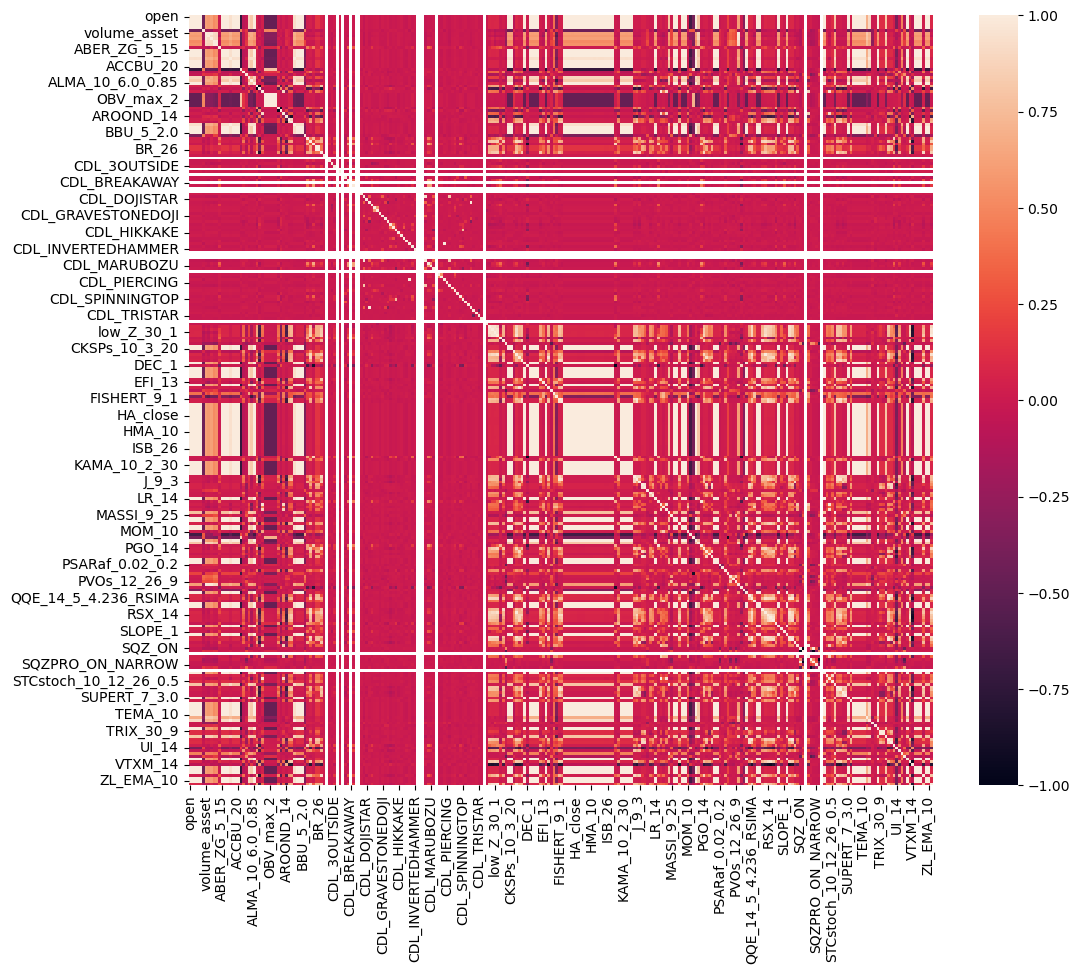

In [9]:
# Again, this analysis should be performed separately for each of the intervals. let's choose some value
interval = 10
print(f"Number of features: {ohlc_data[PAIRS[0]][interval][0].shape[1]}")
# Calculate Pearson Correlation
plt.figure(figsize=(12, 10))
cor = pd.concat(
    [
        pd.concat(
            [ohlc_data[pair][interval][OHLC_INTERVALS[0] * step] for pair in PAIRS]
        )
        for step in range(interval // OHLC_INTERVALS[0])
    ]
).corr()
sns.heatmap(cor)
plt.show()

Some columns have no variance, contain only 1 value - not useful features, so we remove them.

In [10]:
def remove_no_variance_features(ohlc_data):
    for interval in OHLC_INTERVALS:

        columns_lists = []
        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                columns_lists.append(ohlc_data[pair][interval][offset].columns.values)
        all_columns = []
        [all_columns.extend(cols) for cols in columns_lists]
        all_columns = list(set(all_columns))

        no_variance_columns = []
        for col in all_columns:
            col_values = []
            for pair in PAIRS:
                for step in range(interval // OHLC_INTERVALS[0]):
                    offset = OHLC_INTERVALS[0] * step
                    col_values.extend(ohlc_data[pair][interval][offset][col].unique())
            col_values = list(set(col_values))
            if len(col_values) <= 1:
                no_variance_columns.append(col)

        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                for col in no_variance_columns:
                    ohlc_data[pair][interval][offset].pop(col)

    return ohlc_data

In [11]:
ohlc_data = remove_no_variance_features(ohlc_data)

Number of features: 265


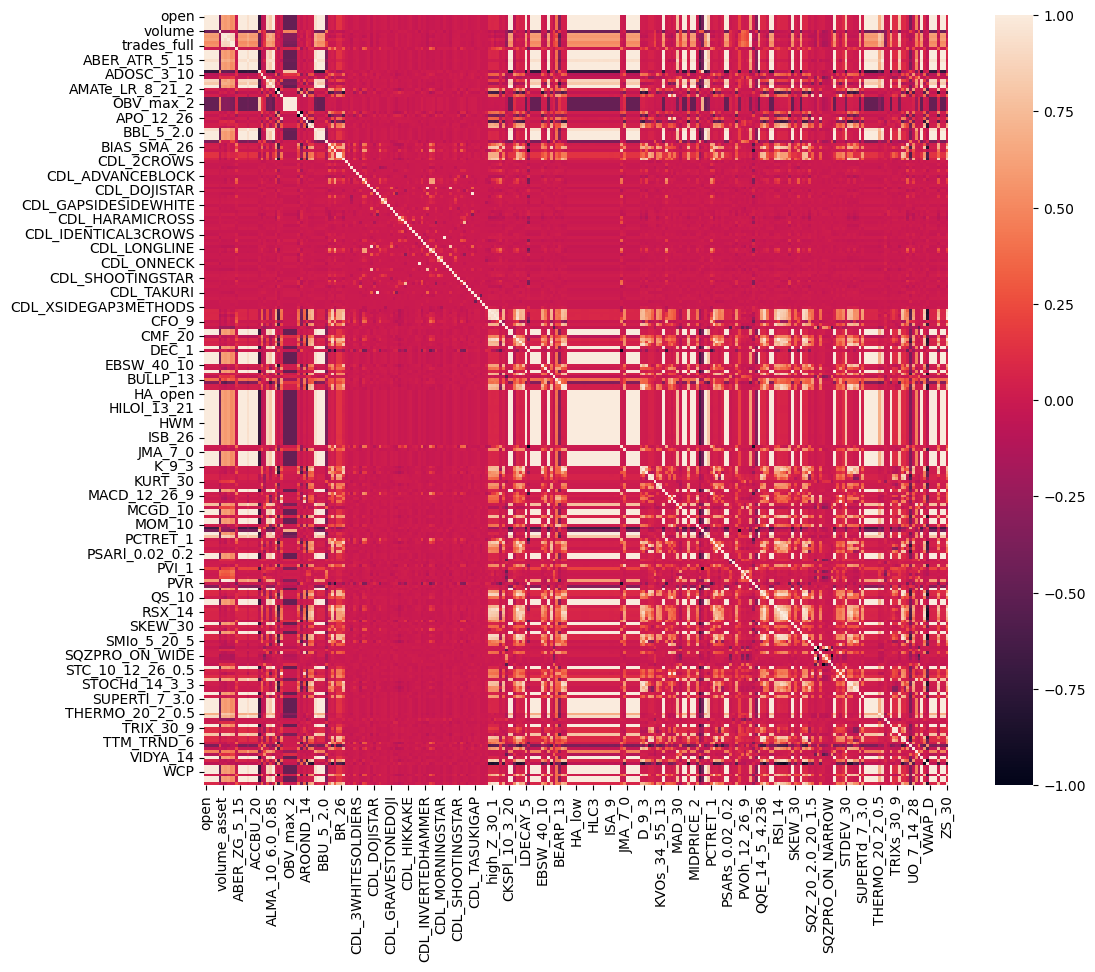

In [12]:
# Now we have only important features (with variance)
print(f"Number of features: {ohlc_data[PAIRS[0]][interval][0].shape[1]}")
plt.figure(figsize=(12, 10))
cor = pd.concat(
    [
        pd.concat(
            [ohlc_data[pair][interval][OHLC_INTERVALS[0] * step] for pair in PAIRS]
        )
        for step in range(interval // OHLC_INTERVALS[0])
    ]
).corr()
sns.heatmap(cor)
plt.show()

Some features can be redundant.
So now we are creating a square matrix with dimensions equal to the number of features.
In which we will have the elements as the absolute value of correlation between the two features.
Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1.
It does not matter that we select the upper triangular or lower triangular part of the correlation matrix,
but we should not include the diagonal elements.

In [13]:
upper_tri = cor.abs().where(np.triu(np.ones(cor.shape), k=1).astype(bool))
upper = [column for column in upper_tri.columns if any(upper_tri[column] == 1)]

lower_tri = cor.abs().where(np.tril(np.ones(cor.shape), k=-1).astype(bool))
lower = [column for column in lower_tri.columns if any(lower_tri[column] == 1)]

print(upper, lower)

['CDL_ONNECK', 'HWMA_0.2_0.1_0.1', 'OHLC4', 'QTL_30_0.5', 'SQZPRO_20_2.0_20_2_1.5_1', 'SQZPRO_ON_NORMAL', 'STCmacd_10_12_26_0.5', 'ZS_30'] ['CDL_INNECK', 'close_Z_30_1', 'HA_close', 'HWM', 'MACD_12_26_9', 'MEDIAN_30', 'SQZ_20_2.0_20_1.5', 'SQZ_ON']


It is easy to see that the above 2 sets of features are identical

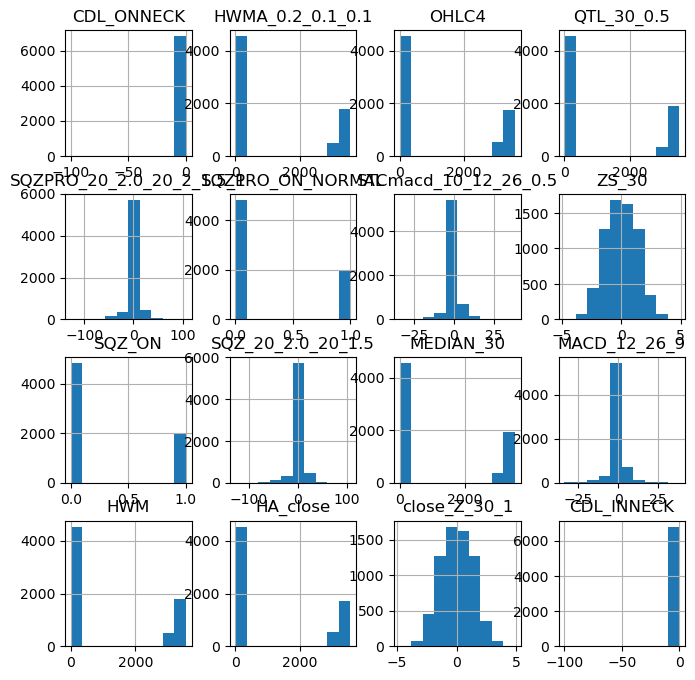

In [14]:
hist = pd.concat([ohlc_data[pair][interval][0] for pair in PAIRS])[
    upper + lower[::-1]
].hist()

We don't need repeated features, so we are selecting the columns which are having absolute correlation equal 1 and drop them
You can change the threshold value from 1 to slightly lower, then not only repeated features but also highly correlated will be dropped. Please note that OHLC alone is correlated at 0.99999 level.

In [15]:
def remove_redundant_features(ohlc_data):
    for interval in OHLC_INTERVALS:
        cor = (
            pd.concat(
                [
                    pd.concat(
                        [
                            ohlc_data[pair][interval][OHLC_INTERVALS[0] * step]
                            for pair in PAIRS
                        ]
                    )
                    for step in range(interval // OHLC_INTERVALS[0])
                ]
            )
            .corr()
            .abs()
        )

        upper_tri = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
        to_drop = [
            column for column in upper_tri.columns if any(upper_tri[column] == 1)
        ]

        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                ohlc_data[pair][interval][offset].drop(to_drop, axis=1, inplace=True)

    return ohlc_data

In [16]:
ohlc_data = remove_redundant_features(ohlc_data)

Duplicate columns have been removed

In [17]:
cor = pd.concat(
    [
        pd.concat(
            [ohlc_data[pair][interval][OHLC_INTERVALS[0] * step] for pair in PAIRS]
        )
        for step in range(interval // OHLC_INTERVALS[0])
    ]
).corr()

upper_tri = cor.abs().where(np.triu(np.ones(cor.shape), k=1).astype(bool))
upper = [column for column in upper_tri.columns if any(upper_tri[column] == 1)]
lower_tri = cor.abs().where(np.tril(np.ones(cor.shape), k=-1).astype(bool))
lower = [column for column in lower_tri.columns if any(lower_tri[column] == 1)]

print(upper, lower)

[] []


We need to normalize OHLC indicators and those that are strongly corelated with price values (all PRICE_COL).
In order to be able to compare different pairs (different value) and different time intervals (different variability, percentage change between time steps),
it is necessary to scale these values. we subtract (and then divide by) from value(t=i) the value of the closing price
in the last observed time step CLOSE (t=0).
In this way, the closing price in the last time step will always be zero, and it is possible to compare
price (and price indicators) chenges from different pairs and difriend datetimes.


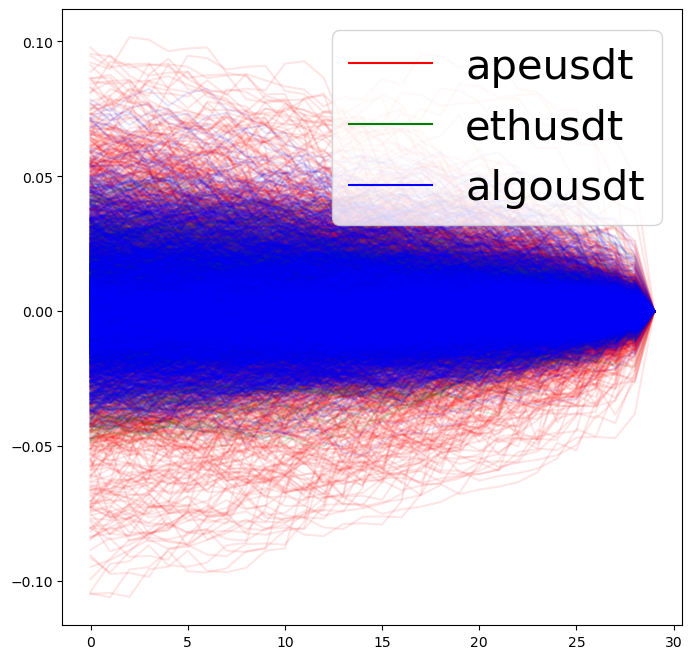

In [18]:
interval = 10
offset = 0
colors = ["red", "green", "blue", "cyan", "magenta", "yellow" "black"]

for it, (pair, dfs) in enumerate(ohlc_data.items()):
    for i in range(DATASET_SEQ_LEN[interval], dfs[interval][offset].shape[0]):
        plt.plot(
            (
                (
                    dfs[interval][offset]
                    .iloc[i - DATASET_SEQ_LEN[interval] : i]["close"]
                    .values
                    - dfs[interval][offset].iloc[i - 1]["close"]
                )
                / dfs[interval][offset].iloc[i - 1]["close"]
            ),
            color=colors[it],
            alpha=0.1,
        )

lines = [
    Line2D([0, 1], [0, 1], linestyle="-", color=colors[i]) for i in range(len(PAIRS))
]
legend = plt.legend(lines, PAIRS, loc=1, fontsize=30)

The features distribution should come from the standardized normal distribution,
therefore we calculate the variance for each interval, which serves as a normalization coefficients.
To avoid data leakage, coefficients are calculated only on the basis of the training data.

Calculate mean and std for price changes. In order to be able to compare different pairs and different intervals,
we normalize the time series related to the price so that the close value in the last time step is zero.
It is necessary to calculate the standard deviation of price changes during the DATASET_SEQ_LEN period,
so that data can be standardized in order to increase the numerical stability of the model.

In [19]:
def get_dataset_params(ohlc_data):
    result = {}

    if PRICE_SCALING_METHOD == "standarised_pct_chenge":
        result["price_std"] = {
            interval: pd.concat(
                [
                    pd.DataFrame().assign(
                        **{
                            f"change_{i}": ohlc_data[pair][interval][offset]
                            .loc[START_DATE:TRAIN_END]["close"]
                            .pct_change(periods=-i)
                            for i in range(1, DATASET_SEQ_LEN[interval])
                        }
                    )
                    for pair in PAIRS
                    for offset in [
                        OHLC_INTERVALS[0] * step
                        for step in range(interval // OHLC_INTERVALS[0])
                    ]
                ]
            )
            .stack()
            .std()
            for interval in OHLC_INTERVALS
        }

    elif PRICE_SCALING_METHOD == "standarised_max_pct_chenge":
        result["price_std"] = {
            interval: pd.concat(
                [
                    pd.DataFrame().assign(
                        **{
                            f"change_{i}": ohlc_data[pair][interval][offset]
                            .loc[START_DATE:TRAIN_END]["close"]
                            .pct_change(periods=-i)
                            for i in range(1, DATASET_SEQ_LEN[interval])
                        }
                    )
                    for pair in PAIRS
                    for offset in [
                        OHLC_INTERVALS[0] * step
                        for step in range(interval // OHLC_INTERVALS[0])
                    ]
                ]
            )
            .max(axis=1)
            .std()
            for interval in OHLC_INTERVALS
        }

    return result

Normalization factor will later be used to normalize input data on the fly by generator during training.

In [20]:
price_normalization_result = get_dataset_params(ohlc_data)
print(price_normalization_result)

{'price_std': {10: 0.01727650098692008, 60: 0.03241411961688421}}


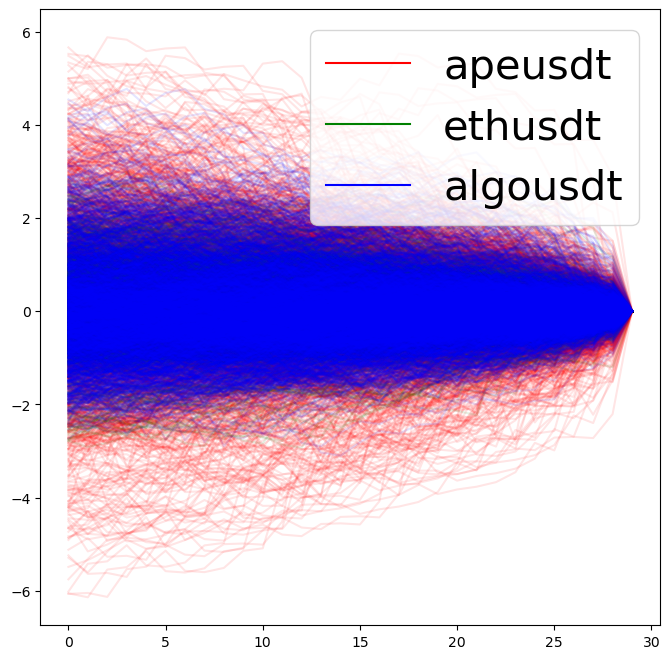

In [21]:
# Result of this standardization.

interval = 10
offset = 0
colors = ["red", "green", "blue", "cyan", "magenta", "yellow" "black"]

for it, (pair, dfs) in enumerate(ohlc_data.items()):
    for i in range(DATASET_SEQ_LEN[interval], dfs[interval][offset].shape[0]):
        plt.plot(
            (
                (
                    dfs[interval][offset]
                    .iloc[i - DATASET_SEQ_LEN[interval] : i]["close"]
                    .values
                    - dfs[interval][offset].iloc[i - 1]["close"]
                )
                / dfs[interval][offset].iloc[i - 1]["close"]
                / price_normalization_result["price_std"][interval]
            ),
            color=colors[it],
            alpha=0.1,
        )

lines = [
    Line2D([0, 1], [0, 1], linestyle="-", color=colors[i]) for i in range(len(PAIRS))
]
_ = plt.legend(lines, PAIRS, loc=1, fontsize=30)

Candle pattern features have values of -100, 0 (most common), and 1 - so - divide by 100.

In [22]:
def normalize_candle_col(ohlc_data):
    for interval in OHLC_INTERVALS:
        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                candle_col_exist = [
                    col
                    for col in CANDLE_COL
                    if col in ohlc_data[pair][interval][offset].columns
                ]
                ohlc_data[pair][interval][offset][candle_col_exist] /= 100

    return ohlc_data

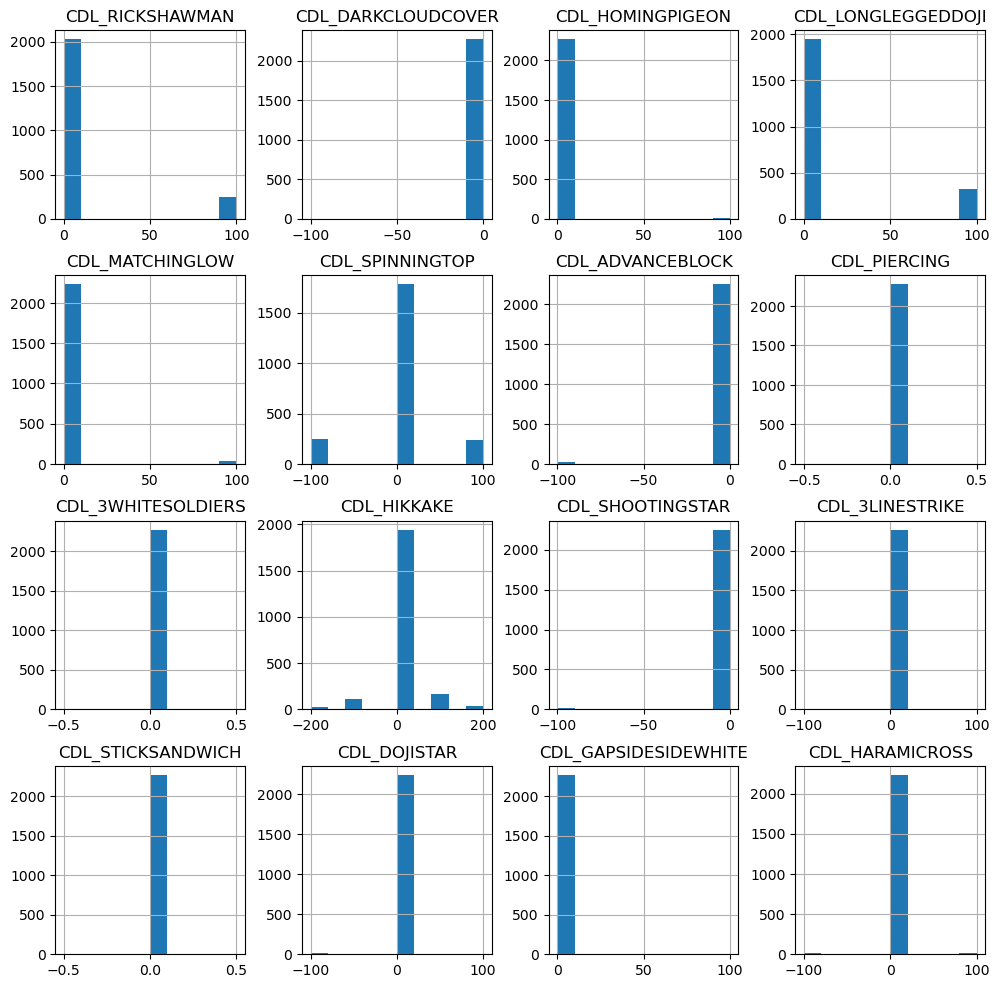

In [23]:
cdl_test_columns = [
    cdl
    for cdl in CANDLE_COL
    if cdl in ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0].columns.values
][:16]
hist = ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0][cdl_test_columns].hist(
    figsize=(12, 12)
)

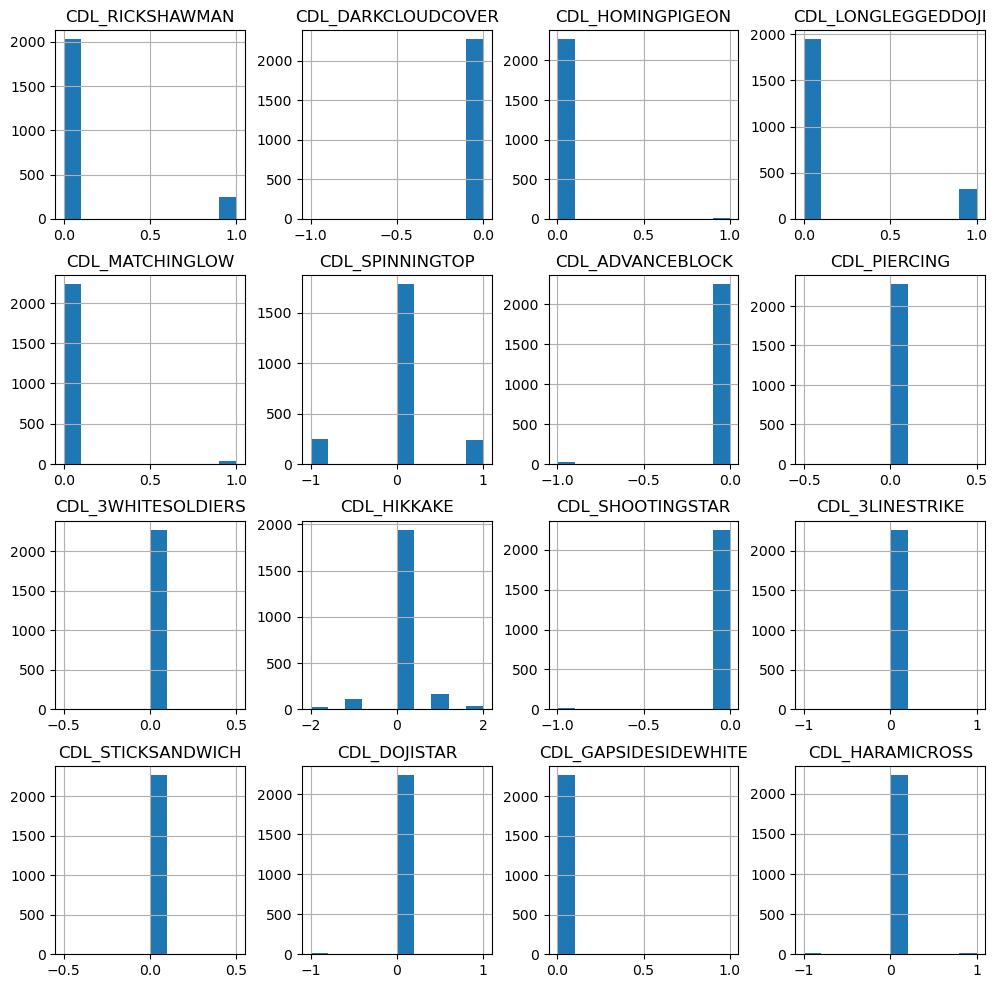

In [24]:
# Normalize CDL columns
ohlc_data = normalize_candle_col(ohlc_data)
hist = ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0][cdl_test_columns].hist(
    figsize=(12, 12)
)

For other features (which are not related to the price, are not candlestick patterns, they are not in the 0-1 range,)
we use power transform (Yeo-Johnson transformation).
Some distributions are very symmetrical, here power transform will not change much,
but some features are very fat-tailed, such as volum, therefore power transform allows to get a more Gaussian shape.
Normalization coefficients are calculated only for the training part and individually for different intervals.
also we apply zero-mean, unit-variance standarization to the transformed output.
sklearn.preprocessing.PowerTransformer has parameter "standardize" that does exactly that.

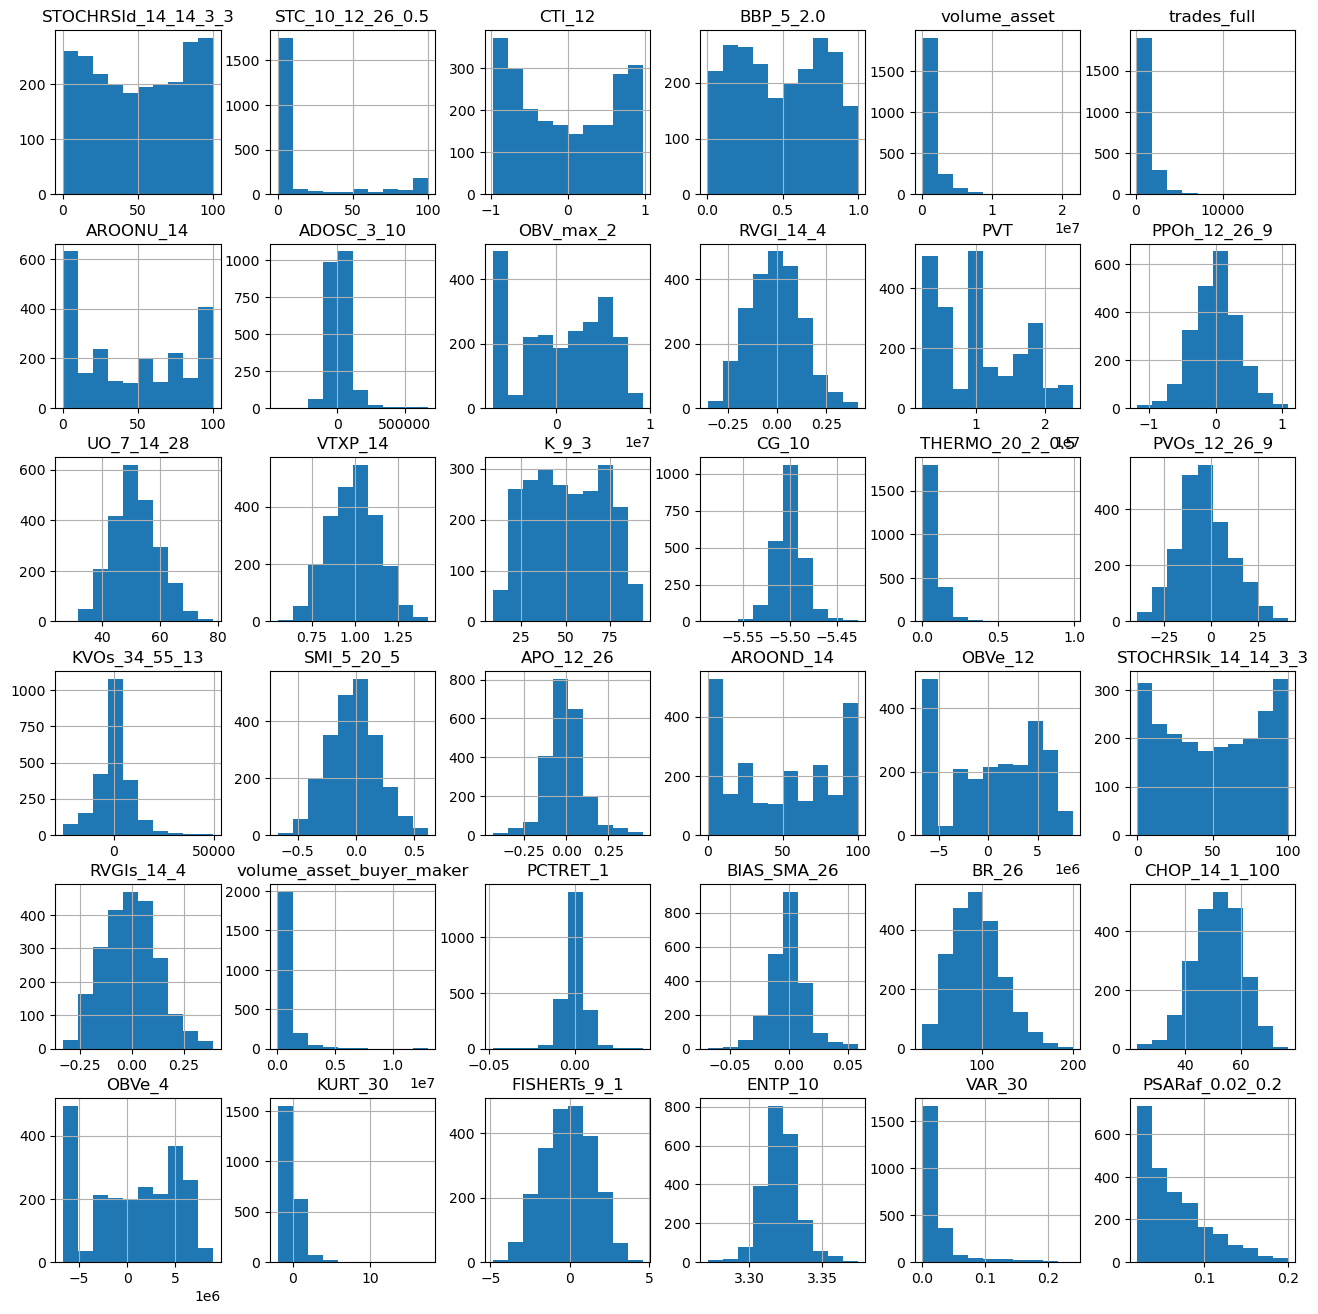

In [25]:
col_names = [
    c
    for c in ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0].columns.values
    if c in OTHER_COL
]

col_names_sample = random.sample(col_names, k=36)
hist = ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0][col_names_sample].hist(
    figsize=(16, 16)
)

In [26]:
def normalize_other_col(ohlc_data):
    result = {}
    for interval in OHLC_INTERVALS:
        other_columns = [
            c for c in ohlc_data[PAIRS[0]][interval][0].columns.values if c in OTHER_COL
        ]

        sc_power = PowerTransformer()
        sc_power.fit(
            pd.concat(
                [
                    pd.concat(
                        [
                            ohlc_data[pair][interval][OHLC_INTERVALS[0] * step].loc[
                                START_DATE:TRAIN_END
                            ][other_columns]
                            for pair in PAIRS
                        ]
                    )
                    for step in range(interval // OHLC_INTERVALS[0])
                ]
            )
        )

        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step
                ohlc_data[pair][interval][offset][other_columns] = sc_power.transform(
                    ohlc_data[pair][interval][offset][other_columns]
                )

        result[interval] = {
            name: {
                "mean": mean_,
                "var": var_,
                "lambda": lambda_,
            }
            for name, mean_, var_, lambda_ in zip(
                other_columns,
                sc_power._scaler.mean_,
                sc_power._scaler.var_,
                sc_power.lambdas_,
            )
        }

    return result

In [27]:
result = normalize_other_col(ohlc_data)
print(result[OHLC_INTERVALS[0]]["volume"])

{'mean': 35.76932307163945, 'var': 209.218683703956, 'lambda': 0.18642602849866446}


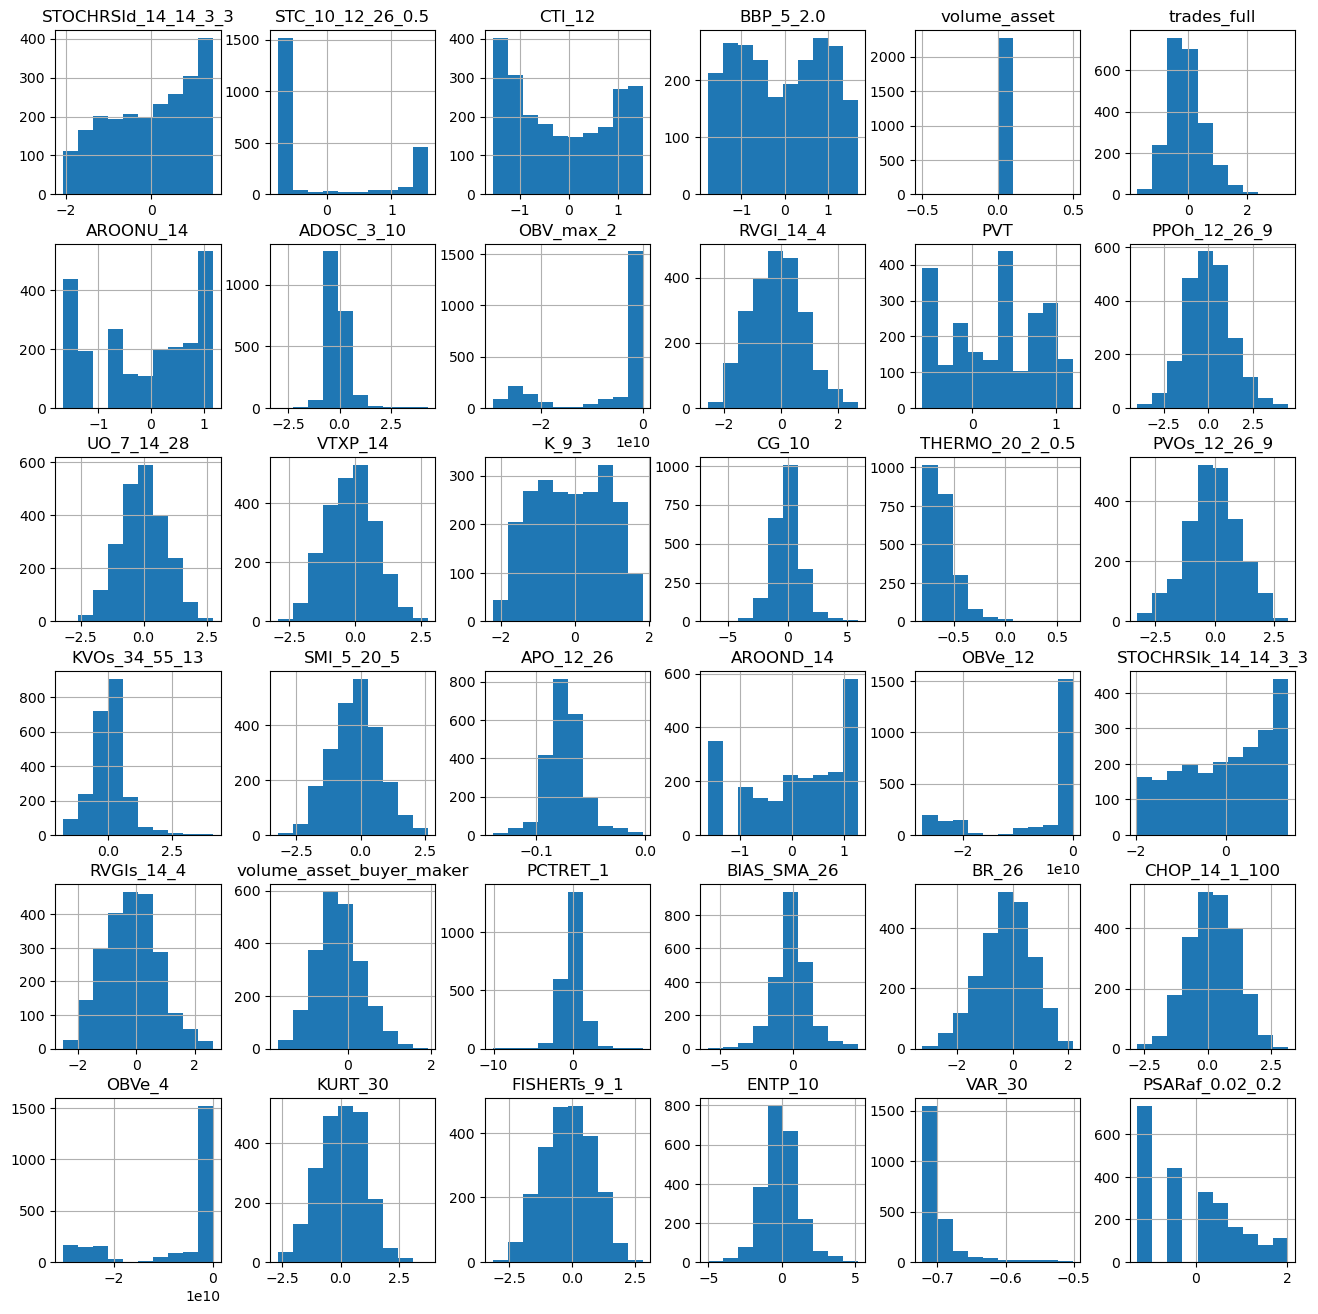

In [28]:
hist = ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0][col_names_sample].hist(
    figsize=(16, 16)
)

PowerTransform allows to map fat-tailed distributions to a normal distribution. However, sometimes we can have problems with numerical volatility, I have observed it with the volume feature and its derivatives, this is the case where the minimum value is most likely 0 (because there are short periods of time where no trade has been recorded) and the maximums can be very large (volume fat-tailed tendency, there are turbulent rare moments with a huge exchange value). For these features, after using power transform normalization, the values was set to zero, which is obviously an error.
The correctness must be checked by examining whether the reverse transformation is possible and whether it returns the correct values. In the next notebook I also use sklearn.preprocessing.QuantileTransformer or a mixture of QuantileTransformer and PowerTransformer to get the correct transformations for all the features.

In QuantileTransformer "The obtained values are then mapped to the desired output distribution using the associated quantile function. Features values of new/unseen data that fall below or above the fitted range will be mapped to the bounds of the output distribution. Note that this transform is non-linear. It may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable." - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

In [29]:
ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0]["volume_asset"]

timestamp
2022-03-25 05:10:00    0.0
2022-03-25 05:20:00    0.0
2022-03-25 05:30:00    0.0
2022-03-25 05:40:00    0.0
2022-03-25 05:50:00    0.0
                      ... 
2022-04-09 23:10:00    0.0
2022-04-09 23:20:00    0.0
2022-04-09 23:30:00    0.0
2022-04-09 23:40:00    0.0
2022-04-09 23:50:00    0.0
Freq: 10T, Name: volume_asset, Length: 2273, dtype: float64

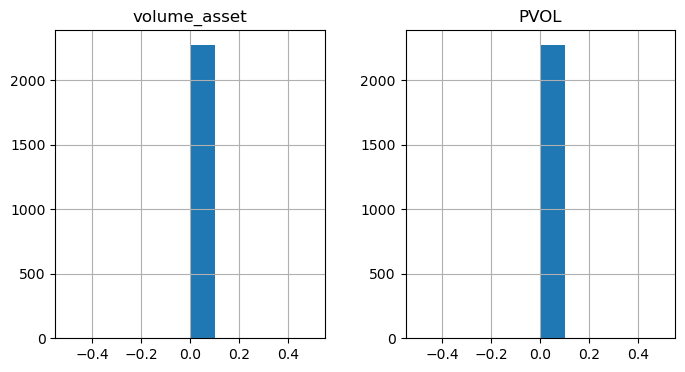

In [30]:
# An example of features that have not been correctly transformed
hist = ohlc_data[PAIRS[0]][OHLC_INTERVALS[0]][0][["volume_asset", "PVOL"]].hist(
    figsize=(8, 4)
)

Not all rows can be used, therefore it is worth dropping unnecessary. Assuming that a sample for all intervals ends at the same time point, there will be samples with larger intervals that will never be used.

In [31]:
# the length of the sequence is 30, so the first 10 min interval we can use as
# the end sample is at position 30 and has a timestamp 2022-03-25 10:00:00
ohlc_data["ethusdt"][10][0].iloc[29:].head(3)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,...,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-25 10:00:00,3135.74,3144.36,3135.00,3137.64,3139.673929,-1.213562,0.0,1.170825,1.192003,0.843997,...,-0.787430,3120.781221,0.308423,-0.329027,3126.006181,3127.722835,3138.6600,1.193879,3129.854909,3135.871682
2022-03-25 10:10:00,3137.64,3138.84,3130.95,3134.52,3135.159900,-1.321720,0.0,0.891657,0.983689,0.497661,...,-0.788642,3120.934203,0.120394,-0.276897,3126.108031,3129.117084,3134.7075,0.887752,3131.232182,3136.380467
2022-03-25 10:20:00,3134.51,3137.66,3131.92,3135.79,3135.123391,-1.411679,0.0,0.604642,0.833287,0.399896,...,-0.807228,3121.828069,1.032608,-0.366548,3126.182953,3130.296605,3135.2900,1.008190,3132.561455,3136.842200


In [32]:
# the corresponding 60 min interval has timestamp 2022-03-25 09:10:00,
# both these intervals end at time t=2022-03-25 10:10:00
# In this case we have 5 lines that will never be used, and we can drop them
ohlc_data["ethusdt"][60][10].iloc[29:].head(7)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,...,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-25 04:10:00,3137.00,3144.79,3130.67,3139.49,3138.507180,-1.378828,0.853349,0.848436,0.860403,0.465532,...,0.887030,3030.439850,2.018357,-0.809369,3122.459661,3113.486229,3138.6100,1.494615,3119.759636,3133.348232
2022-03-25 05:10:00,3139.48,3146.57,3125.62,3135.85,3134.101709,-1.391315,0.816096,0.817455,0.817267,0.288189,...,1.021140,3035.044109,0.797028,-0.104678,3124.156989,3116.914428,3135.9725,0.945497,3123.855273,3137.595826
2022-03-25 06:10:00,3135.84,3146.80,3132.19,3140.46,3139.369536,-1.267258,1.164121,1.021487,1.279784,0.808360,...,1.073776,3038.928135,0.617590,-0.296293,3126.822860,3121.362018,3139.9775,1.338556,3128.154545,3141.991130
2022-03-25 07:10:00,3140.46,3146.54,3108.98,3111.48,3130.121595,-1.207887,1.318200,1.302398,1.333085,0.841618,...,0.824206,3039.902031,-0.033903,-0.238197,3126.039048,3121.018292,3119.6200,-0.595115,3126.443091,3131.801834
2022-03-25 08:10:00,3111.48,3129.83,3096.69,3117.27,3114.856943,-1.191075,1.357834,1.394234,1.322139,1.085759,...,0.741243,3040.432096,-0.057250,-0.091529,3124.250357,3121.274491,3115.2650,-0.363784,3125.656545,3125.119682
2022-03-25 09:10:00,3117.28,3144.36,3114.87,3137.64,3132.239472,-1.342671,0.955210,0.932607,0.978230,0.703656,...,0.806890,3044.475468,-0.004003,-0.178752,3124.903568,3123.833666,3133.6275,1.041295,3128.409455,3127.721558
2022-03-25 10:10:00,3137.64,3155.00,3130.95,3145.50,3143.270456,-1.290030,1.103495,0.964299,1.217364,1.014637,...,0.871790,3049.446297,0.401924,-0.643048,3126.621501,3127.003771,3144.2375,1.115687,3131.937636,3131.870366


In [33]:
def drop_first_unused(ohlc_data):
    for interval in OHLC_INTERVALS[1:]:
        freq = interval // OHLC_INTERVALS[0]
        offsets = [
            OHLC_INTERVALS[0] * step for step in range(interval // OHLC_INTERVALS[0])
        ]
        offsets = sorted(offsets, reverse=True)[:-1]
        offsets.insert(0, 0)
        for pair in PAIRS:
            base_list_len = len(ohlc_data[pair][OHLC_INTERVALS[0]][0])
            first_n_pos = list(
                range(
                    base_list_len - DATASET_SEQ_LEN[OHLC_INTERVALS[0]] + 1,
                    base_list_len - DATASET_SEQ_LEN[OHLC_INTERVALS[0]] + 1 - freq,
                    -1,
                )
            )
            for pos in first_n_pos:
                offset = offsets[(pos - 1) % freq]
                idx = -((pos + freq - 1) // freq)
                to_drop = (
                    len(ohlc_data[pair][interval][offset])
                    + idx
                    - DATASET_SEQ_LEN[interval]
                    + 1
                )
                ohlc_data[pair][interval][offset].drop(
                    index=ohlc_data[pair][interval][offset].index[:to_drop],
                    inplace=True,
                )

    return ohlc_data

In [34]:
ohlc_data = drop_first_unused(ohlc_data)

In [35]:
# let's check it again,
# there are no more lines that will not be used
# first interval has timestamp 2022-03-25 09:10:00
ohlc_data["ethusdt"][60][10].iloc[29:].head(3)

,open,high,low,close,weighted,volume,volume_asset,volume_asset_buyer_maker,volume_asset_buyer_taker,trades,...,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-25 09:10:00,3117.28,3144.36,3114.87,3137.64,3132.239472,-1.342671,0.955210,0.932607,0.978230,0.703656,...,0.806890,3044.475468,-0.004003,-0.178752,3124.903568,3123.833666,3133.6275,1.041295,3128.409455,3127.721558
2022-03-25 10:10:00,3137.64,3155.00,3130.95,3145.50,3143.270456,-1.290030,1.103495,0.964299,1.217364,1.014637,...,0.871790,3049.446297,0.401924,-0.643048,3126.621501,3127.003771,3144.2375,1.115687,3131.937636,3131.870366
2022-03-25 11:10:00,3145.49,3179.37,3142.20,3163.54,3164.011446,-1.079919,1.644465,1.591071,1.689468,1.684944,...,1.278007,3055.986175,0.802383,-1.106435,3132.214408,3136.097690,3162.1625,0.894713,3138.056909,3147.093936


Time as a timestamp is not a useful feature. Using the sin/cos function we can embeded its periodicity.
I have assumed the most basic lengths (like hour, day, week, year) that can generate some periodicity. Even if we do not observe periodicity for these intervals, the notation in trigonometric functions will allow the model to understand the concept of time.

In [36]:
def add_time_features(ohlc_data):
    hour = 60 * 60
    day = 24 * hour
    week = 7 * day
    year = (365.2425) * day

    for interval in OHLC_INTERVALS:
        for pair in PAIRS:
            for step in range(interval // OHLC_INTERVALS[0]):
                offset = OHLC_INTERVALS[0] * step

                # now we dont assume intervals shorther than 1s sow we divide by 10**9 to convert nanoseconds to seconds
                # it can be changed if we want to use shorter interwals.
                # we add half of base_time_offset to get time of
                seconds = (
                    ohlc_data[pair][interval][offset].index.asi8 / 10**9
                    + BASE_TIME_OFFSET.nanos / 10**9 / 2
                )

                ohlc_data[pair][interval][offset]["HOUR_SIN"] = np.sin(
                    seconds * (2 * np.pi / hour)
                )
                ohlc_data[pair][interval][offset]["HOUR_COS"] = np.cos(
                    seconds * (2 * np.pi / hour)
                )
                ohlc_data[pair][interval][offset]["DAY_SIN"] = np.sin(
                    seconds * (2 * np.pi / day)
                )
                ohlc_data[pair][interval][offset]["DAY_COS"] = np.cos(
                    seconds * (2 * np.pi / day)
                )
                ohlc_data[pair][interval][offset]["WEEK_SIN"] = np.sin(
                    seconds * (2 * np.pi / week)
                )
                ohlc_data[pair][interval][offset]["WEEK_COS"] = np.cos(
                    seconds * (2 * np.pi / week)
                )
                ohlc_data[pair][interval][offset]["YEAR_SIN"] = np.sin(
                    seconds * (2 * np.pi / year)
                )
                ohlc_data[pair][interval][offset]["YEAR_COS"] = np.cos(
                    seconds * (2 * np.pi / year)
                )

    return ohlc_data

In [37]:
# simple time embeding
ohlc_data = add_time_features(ohlc_data)

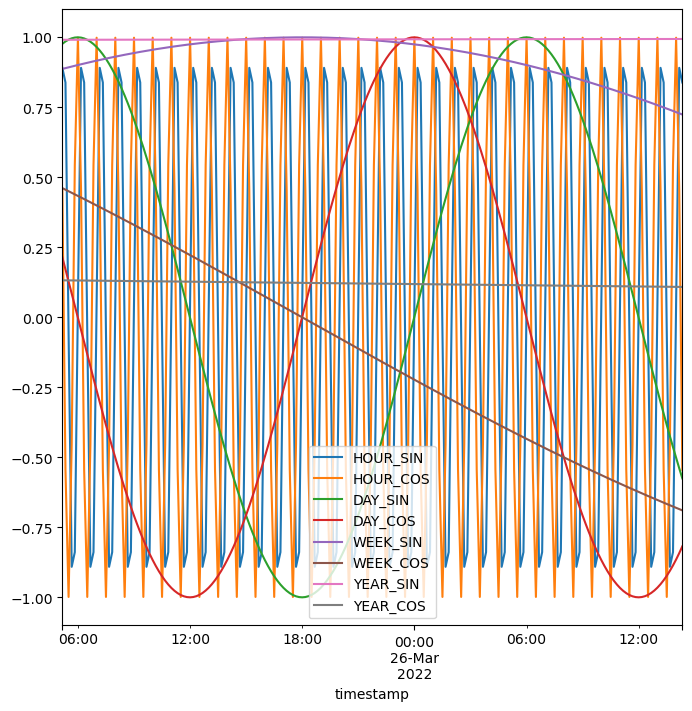

In [38]:
time_cols = [
    "HOUR_SIN",
    "HOUR_COS",
    "DAY_SIN",
    "DAY_COS",
    "WEEK_SIN",
    "WEEK_COS",
    "YEAR_SIN",
    "YEAR_COS",
]
_ = ohlc_data["ethusdt"][10][0][time_cols].iloc[:200].plot()

An action worth considering is the use of PCA decomposition to further reduce the dimensionality of our set of features. However, I have not used it in my considerations so far. In terms of the entire dataset, long-term, the basic features: open, high, low and close are almost identical and using dimensionality reduction could reduce them to a single dimension. further preprocessing is based on the use of specific features, e.g. CLOSE, so it would be hard for me to combine it with PCA.

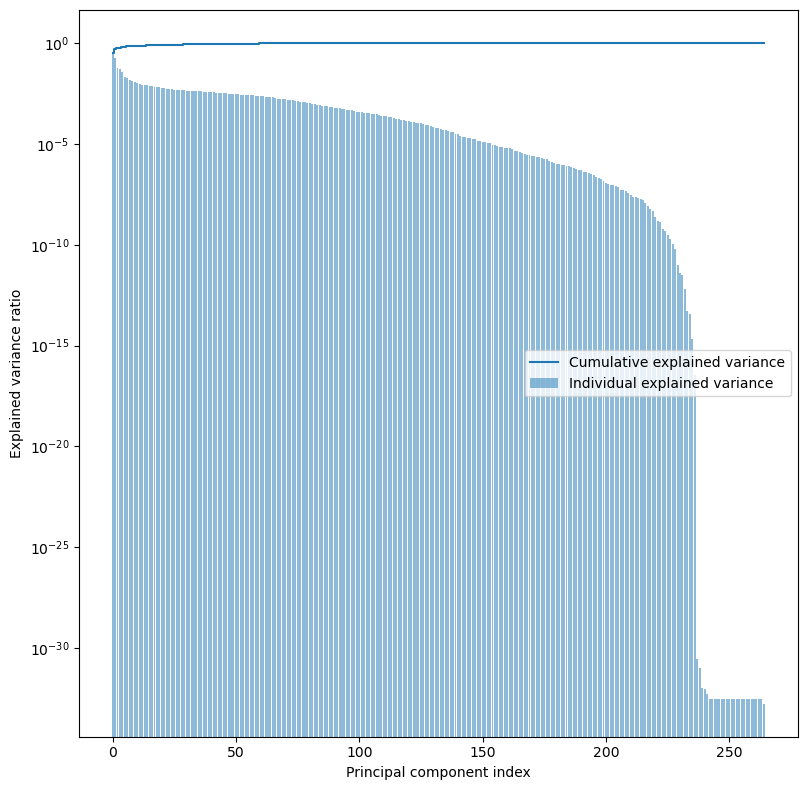

In [39]:
pair = "ethusdt"
interval = 10
offset = 0

sc = StandardScaler()
sc.fit(ohlc_data[pair][interval][offset])
X_train_std = sc.transform(ohlc_data[pair][interval][offset])

# Instantiate PCA
pca = PCA()
# Determine transformed features
X_train_pca = pca.fit_transform(X_train_std)
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.yscale("log")
plt.show()